In [1]:
import json
from chatsky_llm_autoconfig.dialogue import Dialogue
from chatsky_llm_autoconfig.graph import Graph
from chatsky_llm_autoconfig.algorithms.dialogue_generation import (
    RecursiveDialogueSampler,
)

/home/askatasuna/.cache/pypoetry/virtualenvs/chatsky-llm-autoconfiguration-VcuUrJCU-py3.11/lib/python3.11/site-packages/pydantic/_internal/_fields.py:192: UserWarning: Field name "validate" in "Dialogue" shadows an attribute in parent "BaseModel"
  warnings.warn(


In [2]:
with open(
    "/home/askatasuna/Документы/DeepPavlov/chatsky-llm-autoconfig/experiments/2025.01.20_data_generation_pipeline/generated_graphs/generated_graphs_20250125_113113.json"
) as f:
    data = json.load(f)

In [3]:
g = Graph(graph_dict=data[0]["graph"])

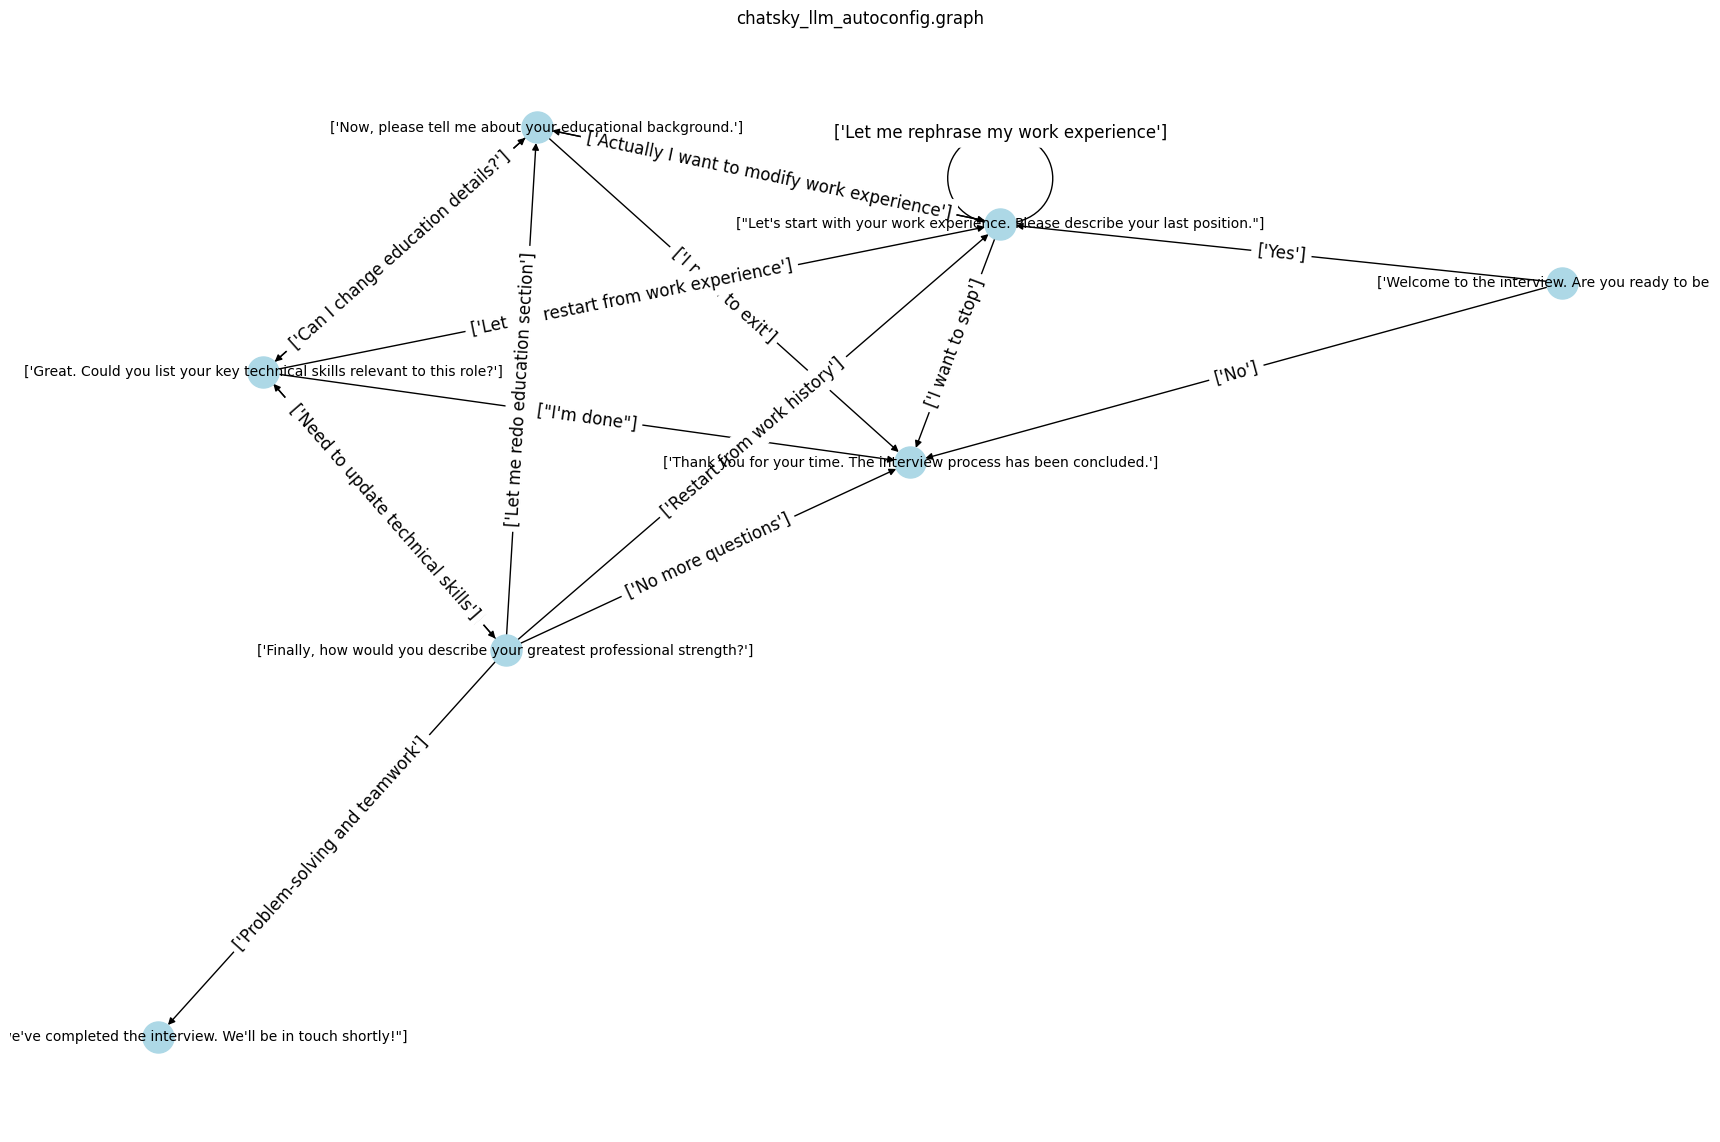

In [4]:
g.visualise()

In [8]:
import itertools
from chatsky_llm_autoconfig.graph import Graph
from chatsky_llm_autoconfig.metrics.automatic_metrics import all_utterances_present


def list_in(a, b):
    return any(map(lambda x: b[x : x + len(a)] == a, range(len(b) - len(a) + 1)))


def all_paths(graph: Graph, start: int, visited: list, repeats: int):
    global visited_list
    if len(visited) < repeats or not list_in(visited[-repeats:] + [start], visited):
        visited.append(start)
        for edge in graph.edge_by_source(start):
            all_paths(graph, edge["target"], visited.copy(), repeats)
    visited_list.append(visited)


def all_combinations(path: list, start: dict, next: int, visited: list):
    global visited_list
    visited.append(start)
    if next < len(path):
        for utt in path[next]["text"]:
            all_combinations(
                path,
                {"participant": path[next]["participant"], "text": utt},
                next + 1,
                visited.copy(),
            )
    visited_list.append(visited)


def get_edges(dialogues: list[list[int]]) -> set[tuple]:
    pairs = []
    for dialogue in dialogues:
        for idx, n in enumerate(dialogue[:-1]):
            pairs.append((n, dialogue[idx + 1]))
    return set(pairs)


def edges_in(dialogue: list[int], dialogues: list[list[int]]) -> bool:
    return get_edges([dialogue]).issubset(get_edges(dialogues))


def remove_duplicates(dialogues: list[list[int]]) -> list[list[int]]:
    ds_copy = dialogues.copy()
    idx = 0
    for dialogue in dialogues:
        if edges_in(dialogue, ds_copy[:idx] + ds_copy[idx + 1 :]):
            ds_copy = ds_copy[:idx] + ds_copy[idx + 1 :]
        else:
            idx += 1
    return ds_copy


def get_utts(seq: list[list[dict]]) -> set[tuple[str]]:
    res = []
    for dialogue in seq:
        user_texts = [d["text"] for d in dialogue if d["participant"] == "user"]
        assist_texts = [d["text"] for d in dialogue if d["participant"] == "assistant"]
        res.extend([(a, u) for u, a in zip(user_texts, assist_texts)])
    return set(res)


def remove_duplicated_utts(seq: list[list[dict]]):
    seq_copy = seq.copy()
    idx = 0
    for s in seq:
        if get_utts([s]).issubset(get_utts(seq_copy[:idx] + seq_copy[idx + 1 :])):
            seq_copy = seq_copy[:idx] + seq_copy[idx + 1 :]
        else:
            idx += 1
    return seq_copy


def get_dialogues(graph: Graph, repeats: int) -> list[Dialogue]:
    global visited_list
    paths = []
    starts = [n for n in graph.graph_dict.get("nodes") if n["is_start"]]
    for s in starts:
        visited_list = [[]]
        all_paths(graph, s["id"], [], repeats)
        paths.extend(visited_list)

    paths.sort()
    final = list(k for k, _ in itertools.groupby(paths))[1:]
    final.sort(key=len, reverse=True)
    sources = list(set([g["source"] for g in graph.graph_dict["edges"]]))
    # ends = [g['id'] for g in graph.graph_dict['nodes'] if g['id'] not in sources]
    # node_paths = [f for f in final if f[-1] in ends]
    node_paths = remove_duplicates(final)
    # node_paths = remove_duplicates(node_paths)
    full_paths = []
    for p in node_paths:
        path = []
        for idx, s in enumerate(p[:-1]):
            path.append(
                {"participant": "assistant", "text": graph.node_by_id(s)["utterances"]}
            )
            sources = graph.edge_by_source(s)
            targets = graph.edge_by_target(p[idx + 1])
            edge = [e for e in sources if e in targets][0]
            path.append(({"participant": "user", "text": edge["utterances"]}))
        path.append(
            {"participant": "assistant", "text": graph.node_by_id(p[-1])["utterances"]}
        )
        full_paths.append(path)
    dialogues = []
    for f in full_paths:
        visited_list = [[]]
        all_combinations(f, {}, 0, [])
        dialogue = [el[1:] for el in visited_list if len(el) == len(f) + 1]
        dialogues.extend(dialogue)
    final = list(k for k, _ in itertools.groupby(dialogues))
    final = remove_duplicated_utts(final)
    result = [Dialogue.from_list(seq) for seq in final]
    return result


def get_full_dialogues(graph: Graph, upper_limit: int):
    repeats = 1
    while repeats <= upper_limit:
        dialogues = get_dialogues(graph, repeats)
        if all_utterances_present(graph, dialogues):
            print(f"{repeats} repeats works!")
            break
        repeats += 1
    if repeats >= upper_limit:
        print("Not all utterances present")
    return dialogues

In [5]:
s = RecursiveDialogueSampler()
with open("graph.json", "w") as f:
    json.dump(
        {
            "graph": data[0]["graph"],
            "topic": data[0]["topic"],
            "dialogues": [x.to_list() for x in s.invoke(g, 10)],
        },
        f,
    )

1 repeats works!


In [6]:
s.invoke(g, 10)

1 repeats works!


[Dialogue(messages=[DialogueMessage(text='Welcome to the interview. Are you ready to begin?', participant='assistant'), DialogueMessage(text='Yes', participant='user'), DialogueMessage(text="Let's start with your work experience. Please describe your last position.", participant='assistant'), DialogueMessage(text='Worked as software developer for 5 years', participant='user'), DialogueMessage(text='Now, please tell me about your educational background.', participant='assistant'), DialogueMessage(text="Bachelor's in Computer Science", participant='user'), DialogueMessage(text='Great. Could you list your key technical skills relevant to this role?', participant='assistant'), DialogueMessage(text='Python, SQL, cloud technologies', participant='user'), DialogueMessage(text='Finally, how would you describe your greatest professional strength?', participant='assistant'), DialogueMessage(text='Restart from work history', participant='user'), DialogueMessage(text="Let's start with your work ex

In [11]:
with open("dialogues.txt", "w") as f:
    for d in get_full_dialogues(g, 10):
        f.write(str(d))
        f.write("\n\n-----------------------------------\n\n")

1 repeats works!
